# 3D *tobac* Tutorial: Gridded Radar Data

This tutorial will demonstrate how to use *tobac* to detect and track convection with gridded radar data. Because this tutorial uses 3D feature detection, you must use the v1.5 beta (3D and PBC changes) of *tobac*. 

In [54]:
%matplotlib inline

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import cartopy.feature as cfeature
import seaborn as sns
import xarray as xr
import pyart
import glob
import datetime
import matplotlib.gridspec as gridspec
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


In [3]:
def convert_gr_table(grstr):
    spstr = grstr.split("color:")
    spstr = [x.strip() for x in spstr]
    varvalues = list()
    red1values = list()
    red2values = list()
    blue1values = list()
    blue2values = list()
    green1values = list()
    green2values = list()

    for interval in spstr:
        if interval == '':
            continue
        indivals = interval.split()
        varvalues.append(int(indivals[0]))
        red1values.append(int(indivals[1]))
        green1values.append(int(indivals[2]))
        blue1values.append(int(indivals[3]))
        if len(indivals)<5:
            #we aren't discontinuous here.
            red2values.append(-1)
            green2values.append(-1)
            blue2values.append(-1)
        else:
            red2values.append(int(indivals[4]))
            green2values.append(int(indivals[5]))
            blue2values.append(int(indivals[6]))
    
    normvarvals = [(x+(0-min(varvalues)))/
                   (max(varvalues)+(0-min(varvalues))) for x in varvalues]
    red1values = [x/255.0 for x in red1values]
    red2values = [x/255.0 for x in red2values]
    green1values = [x/255.0 for x in green1values]
    green2values = [x/255.0 for x in green2values]
    blue1values = [x/255.0 for x in blue1values]
    blue2values = [x/255.0 for x in blue2values]
    redvals = list()
    greenvals = list()
    bluevals = list()
    for i, num in enumerate(normvarvals):
        if i == 0:
            redvals.append((num, 0.0, red1values[i]))
            greenvals.append((num, 0.0, green1values[i]))
            bluevals.append((num, 0.0, blue1values[i]))
        
        else:
            if red2values[i-1]<0:
                redvals.append((num, red1values[i], red1values[i]))
                greenvals.append((num, green1values[i], green1values[i]))
                bluevals.append((num, blue1values[i], blue1values[i]))

            else:
                redvals.append((num, red2values[i-1], red1values[i]))
                greenvals.append((num, green2values[i-1], green1values[i]))
                bluevals.append((num, blue2values[i-1], blue1values[i]))

    cmapdict = {
        'red':tuple(redvals),
        'green':tuple(greenvals),
        'blue':tuple(bluevals)
    }
    return cmapdict

In [4]:
grctable = """color: -30 116 78 173 147 141 117
color: -20 150 145 83 210 212 180
color: -10 204 207 180 65 91 158
color: 10 67 97 162 106 208 228
color: 18 111 214 232 53 213 91
color: 22 17 213 24 9 94 9
color: 35 29 104 9 234 210 4 
color: 40 255 226 0 255 128 0
color: 50 255 0 0 113 0 0
color: 60 255 255 255 255 146 255
color: 65 255 117 255 225 11 227
color: 70 178 0 255 99 0 214
color: 75 5 236 240 1 32 32
color: 85 1 32 32
color: 95 1 32 32"""



In [5]:
wdtbtable = convert_gr_table(grctable)
wdbt = LinearSegmentedColormap('wdtbtable', wdtbtable)
plt.register_cmap(cmap=wdbt)


In [63]:
# Read the data that is in antenna coordinates for all radars
all_radar_data = dict()
for radar_file_name in sorted(glob.glob("/Users/sfreeman/Documents/Research/tobac_dev/eye_candy/radar_data/KCYS_20170525/KCYS20170525*")):
    radar_time_str = radar_file_name.split('/')[-1][4:-4]
    radar_time = datetime.datetime.strptime(radar_time_str, '%Y%m%d_%H%M%S')
    all_radar_data[radar_time] = pyart.io.read(radar_file_name)


In [64]:
# We can create a Grid object from a Radar object by using pyart.map.grid_from_radars()
# Grid shape is the amount of points within a dimension. Grid limits is the dimension limits
# in meters.
all_radar_gridded = dict()
for radar_time in all_radar_data:
    all_radar_gridded[radar_time] = pyart.map.grid_from_radars(all_radar_data[radar_time], grid_shape=(41, 401, 401),
                                  grid_limits=((0.,20000,), (-200000., 200000.), (-200000, 200000.)))


In [67]:
all_times = list(all_radar_gridded)

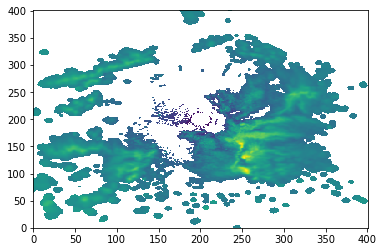

In [69]:
plt.pcolormesh(all_radar_gridded[all_times[3]].to_xarray()['reflectivity'][0,6])

In [70]:
# Setting projection and ploting the second tilt
proj = ccrs.PlateCarree()


In [71]:
all_xr_grids = list()
for radar_time in all_radar_gridded:
    all_xr_grids.append(all_radar_gridded[radar_time].to_xarray())

In [72]:
all_xr_data = xr.concat(all_xr_grids, 'time')

In [73]:
import sys
sys.path.append("/Users/sfreeman/Documents/Research/tobac_dev/tobac-csu/")
import tobac
import tobac.testing
import tobac.feature_detection
import tobac.segmentation
import imp
imp.reload(tobac)
imp.reload(tobac.feature_detection)



<module 'tobac.feature_detection' from '/Users/sfreeman/Documents/Research/tobac_dev/tobac-csu/tobac/feature_detection.py'>

In [74]:
feature_detection_params = dict()
feature_detection_params['threshold'] = [30, 40, 50]
feature_detection_params['target'] = 'maximum'
feature_detection_params['position_threshold'] = 'weighted_diff'
feature_detection_params['n_erosion_threshold'] = 2
feature_detection_params['sigma_threshold'] = 1
feature_detection_params['n_min_threshold'] = 4


In [75]:
xr_grid_full = all_xr_data['reflectivity']
xr_grid_full['z'] = xr_grid_full.z.assign_attrs({'standard_name': 'altitude'})
xr_grid_full['lat'] = xr_grid_full.lat.assign_attrs({'standard_name': 'latitude'})
xr_grid_full['lon'] = xr_grid_full.lon.assign_attrs({'standard_name': 'longitude'})



In [76]:
grid_iris = xr_grid_full.to_iris()


In [77]:
out_fd = tobac.feature_detection_multithreshold(grid_iris, 0, **feature_detection_params)

In [78]:
out_fd

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,altitude,projection_y_coordinate,projection_x_coordinate,latitude,longitude
0,0,1,7.068803,101.211213,243.209585,604,30,1,2017-05-25 17:26:49,2017-05-25 17:26:49,3534.401549,-98788.787273,43209.585379,40.239296,-104.303573
1,0,2,6.323391,128.182902,246.309060,77,30,2,2017-05-25 17:26:49,2017-05-25 17:26:49,3161.695734,-71817.098037,46309.059682,40.481731,-104.267532
2,0,3,3.777254,151.520583,242.152049,464,30,3,2017-05-25 17:26:49,2017-05-25 17:26:49,1888.626823,-48479.416521,42152.049269,40.691501,-104.315870
3,0,4,3.076199,166.613288,250.911352,26,30,4,2017-05-25 17:26:49,2017-05-25 17:26:49,1538.099446,-33386.712403,50911.352289,40.827161,-104.214017
4,1,1,7.888155,102.701610,247.217079,684,30,5,2017-05-25 17:31:09,2017-05-25 17:31:09,3944.077652,-97298.390012,47217.078515,40.252693,-104.256974
5,1,2,4.419903,128.993949,247.956499,197,30,6,2017-05-25 17:31:09,2017-05-25 17:31:09,2209.951326,-71006.050519,47956.498951,40.489021,-104.248376
6,1,3,4.071411,154.854719,246.461700,907,30,7,2017-05-25 17:31:09,2017-05-25 17:31:09,2035.705618,-45145.280934,46461.700149,40.721470,-104.265757
7,1,4,2.751201,179.108779,245.680610,9,30,8,2017-05-25 17:31:09,2017-05-25 17:31:09,1375.600341,-20891.220878,45680.610335,40.939476,-104.274840
8,2,1,8.136221,104.295785,251.222258,693,30,9,2017-05-25 17:35:29,2017-05-25 17:35:29,4068.110442,-95704.215097,51222.258374,40.267022,-104.210402
9,2,2,6.191406,129.904229,251.221589,311,30,10,2017-05-25 17:35:29,2017-05-25 17:35:29,3095.702992,-70095.771355,51221.588984,40.497203,-104.210409


In [79]:
out_tracking = tobac.linking_trackpy(out_fd, None, 300, dxy = 2000, v_max=30)

Frame 3: 5 trajectories present.


In [82]:
cell_2_out = out_tracking[out_tracking['cell']==2]

In [114]:
cell_2_out

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,altitude,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell
1,0,2,6.323391,128.182902,246.309060,77,30,2,2017-05-25 17:26:49,2017-05-25 17:26:49,3161.695734,-71817.098037,46309.059682,40.481731,-104.267532,2.0,0 days 00:00:00
5,1,2,4.419903,128.993949,247.956499,197,30,6,2017-05-25 17:31:09,2017-05-25 17:31:09,2209.951326,-71006.050519,47956.498951,40.489021,-104.248376,2.0,0 days 00:04:20
9,2,2,6.191406,129.904229,251.221589,311,30,10,2017-05-25 17:35:29,2017-05-25 17:35:29,3095.702992,-70095.771355,51221.588984,40.497203,-104.210409,2.0,0 days 00:08:40
14,3,2,6.772883,130.859072,254.270990,553,30,15,2017-05-25 17:39:34,2017-05-25 17:39:34,3386.441701,-69140.928243,54270.989694,40.505786,-104.174951,2.0,0 days 00:12:45


In [150]:
def round_seconds(obj: datetime.datetime) -> datetime.datetime:
    if obj.microsecond >= 500_000:
        obj += datetime.timedelta(seconds=1)
    return obj.replace(microsecond=0)


In [157]:
all_xr_data

<xarray.Dataset>
Dimensions:                    (time: 4, z: 41, y: 401, x: 401)
Coordinates:
  * time                       (time) object 2017-05-25 17:26:49.098000 ... 2...
  * z                          (z) float64 0.0 500.0 1e+03 ... 1.95e+04 2e+04
    lat                        (y) float64 39.33 39.34 39.35 ... 42.92 42.92
    lon                        (x) float64 -107.1 -107.1 ... -102.5 -102.5
  * y                          (y) float64 -2e+05 -1.99e+05 ... 1.99e+05 2e+05
  * x                          (x) float64 -2e+05 -1.99e+05 ... 1.99e+05 2e+05
Data variables:
    differential_reflectivity  (time, z, y, x) float32 nan nan nan ... nan nan
    differential_phase         (time, z, y, x) float32 nan nan nan ... nan nan
    spectrum_width             (time, z, y, x) float32 nan nan nan ... nan nan
    cross_correlation_ratio    (time, z, y, x) float32 nan nan nan ... nan nan
    velocity                   (time, z, y, x) float32 nan nan nan ... nan nan
    reflectivity               (time, z, y, x) float32 nan nan nan ... nan nan
    ROI                        (time, z, y, x) float32 7.406e+03 ... 8.406e+03

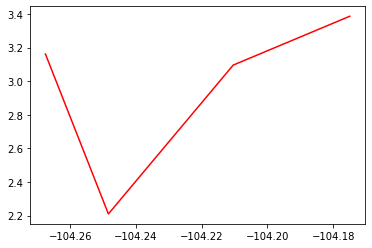

In [180]:
plt.plot(past_time_cell['longitude'].values, past_time_cell['altitude'].values/1000, color='r')

/var/folders/qm/pw51jr5s2qn414149q7_pctr0000gn/T/ipykernel_20700/823106743.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cm = ax.pcolormesh(all_xr_data['lon'][min_x_pt:max_x_pt], (all_xr_data['z']/1000)[min_z_pt:max_z_pt],
/var/folders/qm/pw51jr5s2qn414149q7_pctr0000gn/T/ipykernel_20700/823106743.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cm = ax.pcolormesh(all_xr_data['lon'][min_x_pt:max_x_pt], (all_xr_data['z']/1000)[min_z_pt:max_z_pt],
/v

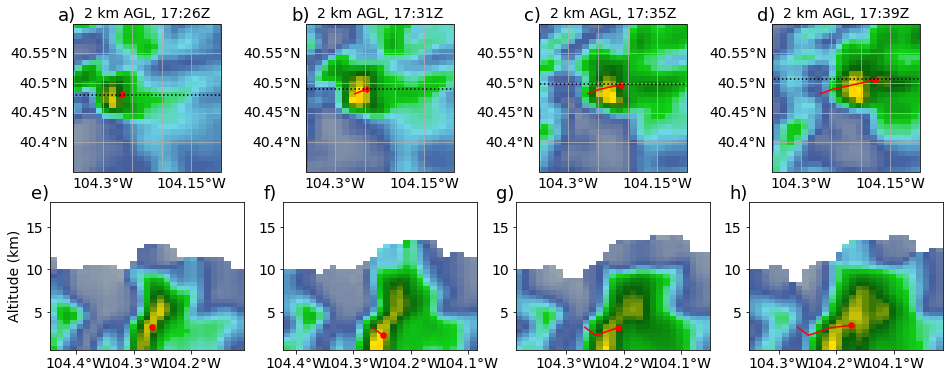

In [207]:
fig = plt.figure(figsize=[16, 6])
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
all_ax = list()
x_range = 15
for i, radar_time in enumerate(all_xr_data.time):
    pydt_radar = datetime.datetime.strptime(str(radar_time.values),'%Y-%m-%d %H:%M:%S.%f')
    pydt_radar = round_seconds(pydt_radar)

    ax = fig.add_subplot(spec[0,i], projection=ccrs.PlateCarree())
    all_ax.append(ax)
    curr_xr_data = all_xr_data.sel(time=radar_time)
    ax.set_extent([-104.35, -104.1, 40.35, 40.6], crs=ccrs.PlateCarree())

    cm = ax.pcolormesh(all_xr_data['lon'], all_xr_data['lat'], curr_xr_data['reflectivity'][4], vmin=-30, vmax=95, 
                    transform=ccrs.PlateCarree(), cmap = 'wdtbtable')

    states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize':14}
    gl.ylabel_style = {'fontsize': 14}
    
    #cb = plt.colorbar(cm)
    #cb.set_label("Reflectivity (dBZ)", size=14)
    #cb.ax.tick_params(labelsize=14)
    plt.title("2 km AGL, "+pydt_radar.strftime("%H:%MZ"), size=14)
    #pydt_radar = pydt_radar.replace(microsecond=round(pydt_radar.microsecond, -3))
    curr_time_cell = cell_2_out[cell_2_out['time']==pydt_radar]
    past_time_cell = cell_2_out[cell_2_out['time']<=pydt_radar]
    min_x_pt = round(curr_time_cell['hdim_2'].values[0])-x_range
    max_x_pt = round(curr_time_cell['hdim_2'].values[0])+x_range
    curr_y_pt = round(curr_time_cell['hdim_1'].values[0])

    ax.scatter(curr_time_cell['longitude'], curr_time_cell['latitude'], 30, transform=ccrs.PlateCarree(), color='r')
    ax.plot(past_time_cell['longitude'].values, past_time_cell['latitude'].values, color='r', transform=ccrs.PlateCarree())
    ax.plot([all_xr_data['lon'][min_x_pt], all_xr_data['lon'][max_x_pt]], [all_xr_data['lat'][curr_y_pt], all_xr_data['lat'][curr_y_pt]], color='k', ls=':',
                transform=ccrs.PlateCarree())
    #plt.savefig("./radar_example_2/base_ref_202105261556_withfeatures.png", facecolor='w', bbox_inches='tight')
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
for i, radar_time in enumerate(all_xr_data.time):
    ax = fig.add_subplot(spec[1,i])
    all_ax.append(ax)
    pydt_radar = datetime.datetime.strptime(str(radar_time.values),'%Y-%m-%d %H:%M:%S.%f')
    pydt_radar = round_seconds(pydt_radar)
    curr_xr_data = all_xr_data.sel(time=radar_time)
    curr_time_cell = cell_2_out[cell_2_out['time']==pydt_radar]
    curr_y_pt = round(curr_time_cell['hdim_1'].values[0])
    min_x_pt = round(curr_time_cell['hdim_2'].values[0])-x_range
    max_x_pt = round(curr_time_cell['hdim_2'].values[0])+x_range
    min_z_pt = 1
    max_z_pt = 37
    cm = ax.pcolormesh(all_xr_data['lon'][min_x_pt:max_x_pt], (all_xr_data['z']/1000)[min_z_pt:max_z_pt], 
        curr_xr_data['reflectivity'][min_z_pt:max_z_pt, curr_y_pt, min_x_pt:max_x_pt], cmap = 'wdtbtable',  vmin=-30, vmax=95,)
    past_time_cell = cell_2_out[cell_2_out['time']<=pydt_radar]

    ax.scatter(curr_time_cell['longitude'], curr_time_cell['altitude']/1000, 30, color='r')
    ax.plot(past_time_cell['longitude'].values, past_time_cell['altitude'].values/1000, color='r')
    ax.tick_params(labelsize=14)
    lon_formatter = LongitudeFormatter(number_format='.1f',
                                       dateline_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    if i == 0:
        ax.set_ylabel("Altitude (km)", size=14)

    

label_prefix = ''
label_suffix = ')'
for ax, label in zip(all_ax, 'abcdefghijklmno'):
    ax.text(-0.1,1.02, label_prefix+label+label_suffix, transform=ax.transAxes, size=18)

plt.savefig("3D_track_example.png", dpi=300)